Code adapted from:
Juho Laitala, Mingzhe Jiang, Elise Syrjälä, Emad Kasaeyan Naeini, Antti
Airola, Amir M. Rahmani, Nikil D. Dutt, and Pasi Liljeberg. 2020. Robust
ECG R-peak Detection Using LSTM. In The 35th ACM/SIGAPP Symposium
on Applied Computing (SAC ’20), March 30-April 3, 2020, Brno, Czech Republic
ACM, New York, NY, USA, Article 4, 8 pages. https://doi.org/10.1145/3341105.
3373945

In [1]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(".."))

# Importing needed libraries
from matplotlib import pyplot as plt
from RNN_files import Laitala_data_original_file
import wfdb
from wfdb.io import get_record_list
from wfdb import rdsamp
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.signal import resample_poly


# Now you can import
from RNN_files import Laitala_data_original_file
import tensorflow
from tensorflow.keras import layers, models, Input
import numpy as np

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

Run this cell and not the one after if using simulated diffraction data.

In [3]:

import xarray as xr

path = '/nsls2/users/shasko/Repos/internship_2025/datasets/ds_combined_500_patterns_NaCl.nc'
ds = xr.open_dataset(path, engine="netcdf4")
gaussians = ds["Intensities"]
binary = ds["binary_arr"]
x = ds["tth"].values

window_size = 11753

Run this cell and not the previous one if using simulated Gaussian signals. 

In [4]:
# path = '/nsls2/users/shasko/Repos/internship_2025/datasets/math_functions_smalldataset.nc' 
# ds = xr.open_dataset(path, engine="netcdf4")

# gaussians = ds["Gaussians"].values
# binary = ds["BinaryArr"].values
# print(type(binary))


# # for j in range(binary.shape[0]):
# #     idx = np.where(binary[j] == 1)[0][0] # because there's only 1 "1" we can use [0][0]
# #     binary[j][idx - 2] = 1
# #     binary[j][idx - 1] = 1
# #     binary[j][idx + 1] = 1
# #     binary[j][idx + 2] = 1

# x = ds["x"].values
# window_size = 990

In [5]:
ds

<xarray.Dataset>
Dimensions:         (hkl_index: 3, pattern: 500, peak: 64, tth: 11763, variation: 500)
Coordinates:
  * pattern         (pattern) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * tth             (tth) float64 0.0 0.0008502 0.0017 ... 9.998 9.999 10.0
  * variation       (variation) int64 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * peak            (peak) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
  * hkl_index       (hkl_index) object 'h' 'k' 'l'
Data variables:
    Intensities     (pattern, tth) float64 ...
    hkl             (variation, peak, hkl_index) float64 ...
    2theta_calc     (variation, peak) float64 ...
    2theta_nearest  (variation, peak) float64 ...
    intensity       (variation, peak) float64 ...
    binary_arr      (pattern, tth) int64 ...
Attributes:
    CIF:        cif_files/NaCl_cubic.cif
    tth_range:  [ 0 10]

In [6]:
import sklearn
from sklearn.model_selection import train_test_split

tv_gaussians, test_gaussians, tv_binary, test_binary = train_test_split(gaussians, binary, test_size=0.2, shuffle=False)

In [7]:
train_gaussians, val_gaussians, train_binary, val_binary = train_test_split(tv_gaussians, tv_binary, test_size=0.25, shuffle=False)

In [8]:
gauss_signals_train = [signal for signal in train_gaussians]
gauss_signals_val = [signal for signal in val_gaussians]
gauss_signals_test = [signal for signal in test_gaussians]

binary_labels_train = [label for label in train_binary]
binary_labels_val = [label for label in val_binary]
binary_labels_test = [label for label in test_binary]

In [9]:
# import sklearn
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# gauss_signals_train_sc = scaler.fit_transform(gauss_signals_train)
# gauss_signals_test_sc = scaler.transform(gauss_signals_test)

In [10]:
import wfdb
from wfdb.processing import (
    resample_singlechan,
    find_local_peaks,
    correct_peaks,
    normalize_bound
)

In [11]:
def data_generator(signals, labels, win_size, batch_size):
   
    while True:
        X, y = [], []

        while len(X) < batch_size:
            i = np.random.randint(0, len(signals))
            sig = signals[i]
            lbl = labels[i]

            if len(sig) <= win_size + 4:
                continue  # skip short signals

            start = np.random.randint(2, len(sig) - win_size - 2)
            end = start + win_size

            data_win = sig[start:end]
            label_win = lbl[start:end]

            # Pad 1s ±2 samples around every 1 in label_win
            padded_label = label_win.copy()
            ones = np.where(label_win == 1)[0]
            for p in ones:
                for offset in [-2, -1, 1, 2]:
                    if 0 <= p + offset < win_size:
                        padded_label[p + offset] = 1

            # Normalize signal window to (0, 1)
            # data_win = normalize_bound(data_win, lb=0, ub=1)

            # Normalized locally
            data_win = (data_win - np.min(data_win))/(np.max(data_win) - np.min(data_win))

            # Normalized globally
            # low = np.min(signals)
            # high = np.max(signals)
            # data_win = (data_win - low)/(high - low)

            X.append(data_win)
            y.append(padded_label)

        X = np.array(X).reshape(batch_size, win_size, 1)
        y = np.array(y).reshape(batch_size, win_size, 1).astype(int)

        yield X, y

In [12]:
gen = data_generator(gauss_signals_train, binary_labels_train, win_size=window_size, batch_size=64)
X_batch, y_batch = next(gen)

In [13]:
n = next(gen)

<class 'tuple'>
2
(64, 11753, 1)
(64, 11753, 1)


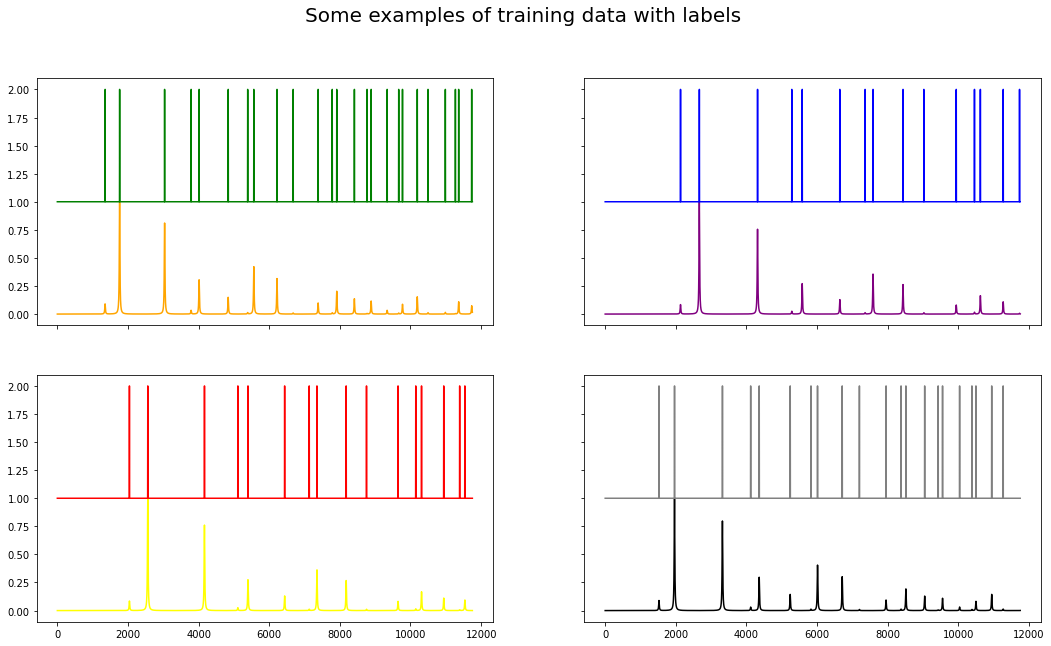

In [14]:

print(type(n))         # likely a tuple
print(len(n))          # 2: probably (inputs, labels)
print(n[0].shape)      # input batch shape
print(n[1].shape)      # label batch shape

# Plot 4 training examples with labels
fig, axs = plt.subplots(2, 2)
fig.set_figheight(10), fig.set_figwidth(18)
fig.suptitle('Some examples of training data with labels', size=20)

# first index refers to whether it's an input or label, so noisy signal is input and peaks are labels
axs[0, 0].plot(n[0][0], color='orange')
axs[0, 0].plot(n[1][0]+1, color='green')

axs[0, 1].plot(n[0][1], color='purple')
axs[0, 1].plot(n[1][1]+1, color='blue')

axs[1, 0].plot(n[0][2], color='yellow')
axs[1, 0].plot(n[1][2]+1, color='red')

axs[1, 1].plot(n[0][3], color='black')
axs[1, 1].plot(n[1][3]+1, color='grey')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [15]:
n_batch, n_timesteps, n_input_dim = 64, window_size, 1

model = models.Sequential()
model.add(Input(shape=(n_timesteps, n_input_dim)))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


In [16]:
model.summary() # view model architecture

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 11753, 64)         8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 11753, 64)         24832     
_________________________________________________________________
dense (Dense)                (None, 11753, 1)          65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [17]:
checkpoint_path = 'training/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create callback to save model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=2) 

es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=3)

In [18]:
training_gen = data_generator(gauss_signals_train, binary_labels_train, win_size=n_timesteps, batch_size=n_batch)

In [19]:
validation_gen = data_generator(gauss_signals_val, binary_labels_val, win_size=window_size, batch_size=n_batch)

In [ ]:
model.fit(training_gen,
          steps_per_epoch=40,
          epochs=20,
          validation_data=validation_gen,
          callbacks=[cp_callback, es_callback])

Epoch 1/20
12/40 [========>.....................] - ETA: 9:19 - loss: 0.6088 - acc: 0.9083

In [ ]:
testing_gen = data_generator(gauss_signals_test, binary_labels_test, win_size=n_timesteps, batch_size=n_batch)

In [ ]:
gauss_test, label_test = next(testing_gen)

KeyboardInterrupt: 

In [ ]:
label_test.shape

(64, 990, 1)

In [ ]:
binary_pred = model.predict(gauss_test)

In [ ]:
binary_pred.shape

(64, 990, 1)

In [ ]:
np.where(binary_pred[5] > 1e-2)[0]
#binary_pred[5]
binary_pred[5][750:760]

array([[1.7881393e-07],
       [1.4901161e-07],
       [2.3841858e-07],
       [1.4901161e-07],
       [1.1920929e-07],
       [1.1920929e-07],
       [1.7881393e-07],
       [1.1920929e-07],
       [2.0861626e-07],
       [2.0861626e-07]], dtype=float32)

In [ ]:
plt.close('all')

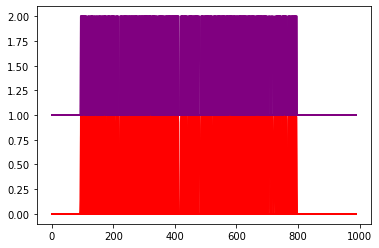

In [ ]:
plt.figure()
for j in range(64):
    plt.plot(binary_pred[j], color='red')
    plt.plot(label_test[j] + 1, color='purple')
plt.show()

In [ ]:
binary_pred.shape

(64, 990, 1)

Unfinished code:

In [ ]:
# evaluate accuracy
# use f1 score, set prob >= 60% as positive, else negative

binary_pred_adjusted = np.zeros_like(binary_pred)

for j in range(binary_pred.shape[0]):
    idx = np.where(binary_pred[j] >= 0.6)[0]
    binary_pred_adjusted[j][idx] = 1


In [ ]:
plt.close('all')

Plot predicted label probabilities, true labels, and diffraction pattern on one set of axes. Note: this only plots one figure at a time to avoid opening too many figures, but some of the patterns have too many peaks to be able to visualize on one set of axes. Manually change the range to visualize other plots in the test dataset.

In [ ]:
plt.figure()

for j in range(1):
    plt.plot(gauss_test[j], color='green', label='Signal')
    plt.plot(binary_pred[j] + 1, color='orange', label='Prediction Probabilities')
    plt.plot(label_test[j] + 2, color='purple', label='True Labels')

plt.tick_params(top=True, bottom=True, left=True, right=True, direction='in')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
# plt.savefig('test_results_multigauss1.png')
plt.show()

NameError: name 'plt' is not defined